# Estudio de las Ventas de una Ferretería
## NB1: Carga y limpieza de los Datos

>Autor: Diana Chacón Ocariz

### Contenido

1. [Introducción](#introduccion)
1. [Fuentes de Datos](#fuentes-datos)
1. [Carga de Librerías](#carga-librerias)
1. [Carga y limpieza de datos del histórico de Ventas (2020)](#carga-historico)
    1. [Archivo hitórico NE](#historico-ne)
    1. [Archivo hitórico FA](#historico-fa) 
1. [Carga y limpieza de datos de Ventas a partir del 2021](#carga-ventas)
    1. [Construcción DF definitivo](#df-definitivo)
1. [Unión del Histórico con las Ventas desde 2021](#total-ventas)
1. [Tasa de Cambio](#tasa-cambio)
    1. [Cálculo Montos en Dólares](#monto_dolares)
1. [Carga y limpieza de datos del Inventario](#carga-inventario)
1. [Almacenamiento de los DF](#almacenamiento-df)

## 1. Introducción<a name="introduccion"></a>

Se trata de una pequeña ferretería que maneja un poco más de 3.000 productos distintos. Poseen un software de gestión genérico que les provee una gran cantidad de reportes, básicamente tablas con números, díficiles de analizar (un reporte puede constar de varias decenas de páginas).

En este **primer notebook del estudio**, cargaremos los datos, los limpiaremos, haremos las transformaciones necesarias y los almacenaremos en diversos formatos (parquet, csv y xlsx) para ser utilizados posteriormente en otros notebooks u otras herramientas.

    
## 2. Fuentes de Datos<a name="fuentes-datos"></a>

Se trata de datos reales provenientes del software de gestión de la empresa. 

Por razones de seguridad, para este estudio eliminamos toda la información concerniente a los clientes. Cualquier uso de los datos fuera de este estudio, deberá ser notificado a la empresa.

Los datos provienen de reportes del software de gestión, Se trata de archivos .xls que contienen sólo datos:

- Histórico de Ventas del 2020: fa_hist_2020.xls y ne_hist_2020.xls
- Ventas por producto del 01/01/2021 al 28/02/2022: fa_art_*.xls y ne_art_*.xls (varios archivos)
- Inventario al 28/02/2022: 2022-02-28-inv.xls

También utilizamos el histórico de la tasa de cambio del dólar para hacer el análisis en base a montos en esta moneda y paliar los problemas de inflación (ver detalle en [NB5: Scraper Tasa de Cambio Dólar](https://github.com/dchaconoca/proyecto-ventas/blob/master/NB5_scraper_tasa_dolar.ipynb))

Todos los archivos se encuentran en el subdirectorio **datos/in**

## 3. Carga de librerías<a name="carga-librerias"></a>

In [1]:
# Librerías utilizadas

import os
import glob
from pathlib import Path

import pandas as pd

In [2]:
BASE_DIR = Path.cwd()
BASE_DIR

PosixPath('/home/diana/Documentos/Ciencia de Datos/Proyecto Ventas')

In [3]:
# Lectura de los archivos y creación de un DF con todos los datos
    
def read_files(FILES, col, long):

    df = pd.DataFrame()

    for filename in glob.glob(f"{BASE_DIR / FILES}"):
        df_aux = pd.read_excel(filename)
        
        info_file = Path(filename).name[:long]
        df_aux[col] = info_file

        df = pd.concat([df, df_aux])

    return df

## 4. Carga y limpieza de datos del histórico de Ventas (2020) <a name="carga-historico"></a>


Tenemos 2 archivos: fa_hist_2020.xls y ne_hist_2020.xls 

Los 2 tienen formato diferente (n° de columnas), pero conservaremos de los 2 la información común, básicamente los datos de una venta.

### 4.A Archivo hitórico NE <a name="historico-ne"></a>

Los datos están agrupados por fecha y contienen un total: Eliminaremos las líneas de encabezado y de totales.Por eso existe un desplazamiento entre el encabezado de las columnas y la verdadera información que contienen.

**Metadatos:**

    - Número: Número de la factura (conservamos como num)       
    - Vendedor: Código del Vendedor (conservamos como vendedor)      
    - Nº Control: Código de control (no conservamos)    
    - Venc.: Fecha de emisión, fecha de la venta (conservamos como fecha_comp: fecha completa)      
    - Neto: Neto o total de la venta (conservamos como monto)

In [4]:
FILES_NE_HIST = 'datos/in/ne_hist*.xls'
FILES_NE_HIST

'datos/in/ne_hist*.xls'

In [5]:
[Path(filename).name for filename in glob.glob(f"{BASE_DIR / FILES_NE_HIST}")]

['ne_hist_2020.xls']

In [6]:
%%time

df_ne_hist = read_files(FILES_NE_HIST, 'tipo', 2)

df_ne_hist

CPU times: user 173 ms, sys: 8.33 ms, total: 181 ms
Wall time: 183 ms


,Número,Vendedor,Nº Control,Venc.,Neto,tipo
0,07/01/2020,NaN,NaN,NaT,NaN,ne
1,0000000001,1.0,07012019,2020-01-07 11:04:00,170601.2,ne
2,Total del Día:,NaN,NaN,NaT,NaN,ne
3,31/01/2020,NaN,NaN,NaT,NaN,ne
4,0000000003,11.0,00-0013,2020-01-31 14:57:00,1661120.0,ne
...,...,...,...,...,...,...
4809,0000004510,7.0,A-311220,2020-12-31 11:43:00,1500000.0,ne
4810,0000004511,7.0,A-311220,2020-12-31 11:46:00,8450000.0,ne
4811,0000004512,14.0,31122020,2020-12-31 12:04:00,5700000.0,ne
4812,Total del Día:,NaN,NaN,NaT,NaN,ne


In [7]:
df_ne_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4814 entries, 0 to 4813
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Número      4814 non-null   object        
 1   Vendedor    4485 non-null   float64       
 2   Nº Control  4485 non-null   object        
 3   Venc.       4485 non-null   datetime64[ns]
 4    Neto       4485 non-null   float64       
 5   tipo        4814 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 225.8+ KB


In [8]:
# Buscamos las filas con valores NaN 
# Corresponden a los encabezados de las ventas del día
# y los totales
df_ne_hist[ df_ne_hist.isnull().values ]

,Número,Vendedor,Nº Control,Venc.,Neto,tipo
0,07/01/2020,NaN,NaN,NaT,NaN,ne
0,07/01/2020,NaN,NaN,NaT,NaN,ne
0,07/01/2020,NaN,NaN,NaT,NaN,ne
0,07/01/2020,NaN,NaN,NaT,NaN,ne
2,Total del Día:,NaN,NaN,NaT,NaN,ne
...,...,...,...,...,...,...
4812,Total del Día:,NaN,NaN,NaT,NaN,ne
4813,Totales:,NaN,NaN,NaT,NaN,ne
4813,Totales:,NaN,NaN,NaT,NaN,ne
4813,Totales:,NaN,NaN,NaT,NaN,ne


In [9]:
# Eliminamos los registros que contienen NaN ya que corresponden a 
df_ne_hist.dropna(inplace=True)
df_ne_hist

,Número,Vendedor,Nº Control,Venc.,Neto,tipo
1,0000000001,1.0,07012019,2020-01-07 11:04:00,170601.2,ne
4,0000000003,11.0,00-0013,2020-01-31 14:57:00,1661120.0,ne
7,0000000004,1.0,05022020,2020-02-05 11:10:00,3365523.6,ne
10,0000000005,1.0,28022020,2020-02-28 14:57:00,150000000.0,ne
13,0000000006,1.0,06032020,2020-03-06 13:56:00,1045740.0,ne
...,...,...,...,...,...,...
4807,0000004508,7.0,A-311220,2020-12-31 11:11:00,12500000.0,ne
4808,0000004509,7.0,A-311220,2020-12-31 11:43:00,4112500.0,ne
4809,0000004510,7.0,A-311220,2020-12-31 11:43:00,1500000.0,ne
4810,0000004511,7.0,A-311220,2020-12-31 11:46:00,8450000.0,ne


In [10]:
# Cambio del nombre de las columnas
df_ne_hist.columns

Index(['Número', 'Vendedor', 'Nº Control', 'Venc.', ' Neto', 'tipo'], dtype='object')

In [11]:
cols = ['num', 
        'vendedor',
        'control',
        'fecha_comp',
        'monto',
        'tipo']

In [12]:
df_ne_hist.columns = cols
df_ne_hist

,num,vendedor,control,fecha_comp,monto,tipo
1,0000000001,1.0,07012019,2020-01-07 11:04:00,170601.2,ne
4,0000000003,11.0,00-0013,2020-01-31 14:57:00,1661120.0,ne
7,0000000004,1.0,05022020,2020-02-05 11:10:00,3365523.6,ne
10,0000000005,1.0,28022020,2020-02-28 14:57:00,150000000.0,ne
13,0000000006,1.0,06032020,2020-03-06 13:56:00,1045740.0,ne
...,...,...,...,...,...,...
4807,0000004508,7.0,A-311220,2020-12-31 11:11:00,12500000.0,ne
4808,0000004509,7.0,A-311220,2020-12-31 11:43:00,4112500.0,ne
4809,0000004510,7.0,A-311220,2020-12-31 11:43:00,1500000.0,ne
4810,0000004511,7.0,A-311220,2020-12-31 11:46:00,8450000.0,ne


In [13]:
df_ne_hist = df_ne_hist.loc[:,['num', 'fecha_comp', 'vendedor', 'monto', 'tipo']]
df_ne_hist

,num,fecha_comp,vendedor,monto,tipo
1,0000000001,2020-01-07 11:04:00,1.0,170601.2,ne
4,0000000003,2020-01-31 14:57:00,11.0,1661120.0,ne
7,0000000004,2020-02-05 11:10:00,1.0,3365523.6,ne
10,0000000005,2020-02-28 14:57:00,1.0,150000000.0,ne
13,0000000006,2020-03-06 13:56:00,1.0,1045740.0,ne
...,...,...,...,...,...
4807,0000004508,2020-12-31 11:11:00,7.0,12500000.0,ne
4808,0000004509,2020-12-31 11:43:00,7.0,4112500.0,ne
4809,0000004510,2020-12-31 11:43:00,7.0,1500000.0,ne
4810,0000004511,2020-12-31 11:46:00,7.0,8450000.0,ne


In [14]:
df_ne_hist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4485 entries, 1 to 4811
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   num         4485 non-null   object        
 1   fecha_comp  4485 non-null   datetime64[ns]
 2   vendedor    4485 non-null   float64       
 3   monto       4485 non-null   float64       
 4   tipo        4485 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 210.2+ KB


### 4.B Archivo hitórico FA <a name="historico-fa"></a>

Existe un desplazamiento entre el encabezado de las columnas y la verdadera información que poseen.

**Metadatos:**

    - Número: Número de la factura (conservamos como num)  
    - Emisión: Fecha de emisión, fecha de la venta (conservamos como fecha_comp: fecha completa)
    - Venc.: Fecha de vencimiento (no conservamos)
    - Vendedor: Código del Vendedor (conservamos como vendedor)    
    - Monto Base: Monto base (no conservamos) 
    - I.V.A.:  IVA (no conservamos)
    - Otros: Otras cargas (no conservamos)
    - Neto: Neto o total de la venta (conservamos como monto)
    - Saldo: Saldo (no conservamos)

Eliminamos las líneas correspondientes a los totales del reporte.

In [15]:
FILES_FA_HIST = 'datos/in/fa_hist*.xls'
FILES_FA_HIST

'datos/in/fa_hist*.xls'

In [16]:
[Path(filename).name for filename in glob.glob(f"{BASE_DIR / FILES_FA_HIST}")]

['fa_hist_2020.xls']

In [17]:
%%time

df_fa_hist = read_files(FILES_FA_HIST, 'tipo', 2)

df_fa_hist

CPU times: user 371 ms, sys: 5.49 ms, total: 376 ms
Wall time: 381 ms


,Número,Emisión,Venc.,Vendedor,Monto Base,I.V.A.,Otros,Neto,Saldo,tipo
0,0000000001,2020-01-06 14:06:00,2020-01-06 14:06:00,3.000000e+00,2077140,0.000000e+00,0,2.077140e+06,0.0,fa
1,0000000002,2020-01-06 14:38:00,2020-01-06 14:38:00,7.000000e+00,174720,0.000000e+00,0,1.747200e+05,0.0,fa
2,0000000003,2020-01-06 14:47:00,2020-01-06 14:47:00,7.000000e+00,101051.03,1.212612e+04,0,1.131771e+05,0.0,fa
3,0000000004,2020-01-06 14:35:00,2020-01-06 14:35:00,1.100000e+01,1465.66,1.758800e+02,0,1.641540e+03,0.0,fa
4,0000000005,2020-01-06 13:58:00,2020-01-06 13:58:00,1.100000e+01,34751.03,5.172000e+01,0,3.480275e+04,0.0,fa
...,...,...,...,...,...,...,...,...,...,...
6505,0000006531,2020-12-30 09:12:00,2020-12-30 09:12:00,7.000000e+00,2500000,4.000000e+05,0,2.900000e+06,0.0,fa
6506,0000006532,2020-12-30 10:48:00,2020-12-30 10:48:00,1.000000e+00,1112500,1.780000e+05,0,1.290500e+06,1290500.0,fa
6507,0000006533,2020-12-30 14:59:00,2021-01-09 14:59:00,7.000000e+00,9275000,1.484000e+06,0,1.075900e+07,0.0,fa
6508,0000006534,2020-12-31 10:03:00,2020-12-31 10:03:00,1.400000e+01,450000,7.200000e+04,0,5.220000e+05,0.0,fa


In [18]:
df_fa_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6510 entries, 0 to 6509
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Número      6510 non-null   object 
 1   Emisión     6510 non-null   object 
 2   Venc.       6510 non-null   object 
 3   Vendedor    6510 non-null   float64
 4   Monto Base  6510 non-null   object 
 5   I.V.A.      6510 non-null   float64
 6   Otros       6510 non-null   object 
 7   Neto        6510 non-null   float64
 8   Saldo       6509 non-null   float64
 9   tipo        6510 non-null   object 
dtypes: float64(4), object(6)
memory usage: 508.7+ KB


In [19]:
# Buscamos las filas con valores NaN 
# Corresponden a los totales del reporte
df_fa_hist[ df_fa_hist.isnull().values ]

,Número,Emisión,Venc.,Vendedor,Monto Base,I.V.A.,Otros,Neto,Saldo,tipo
6509,Totales:,20276869997.040001,1465210270.24,1.532014e+09,Total de ventas a contado:,2.021077e+10,Total de ventas a credito:,1.532014e+09,NaN,fa


In [20]:
# Eliminamos los registros que contienen NaN ya que corresponden a 
# líneas de totales de los reportes 
df_fa_hist.dropna(inplace=True)
df_fa_hist

,Número,Emisión,Venc.,Vendedor,Monto Base,I.V.A.,Otros,Neto,Saldo,tipo
0,0000000001,2020-01-06 14:06:00,2020-01-06 14:06:00,3.0,2077140,0.00,0,2.077140e+06,0.0,fa
1,0000000002,2020-01-06 14:38:00,2020-01-06 14:38:00,7.0,174720,0.00,0,1.747200e+05,0.0,fa
2,0000000003,2020-01-06 14:47:00,2020-01-06 14:47:00,7.0,101051.03,12126.12,0,1.131771e+05,0.0,fa
3,0000000004,2020-01-06 14:35:00,2020-01-06 14:35:00,11.0,1465.66,175.88,0,1.641540e+03,0.0,fa
4,0000000005,2020-01-06 13:58:00,2020-01-06 13:58:00,11.0,34751.03,51.72,0,3.480275e+04,0.0,fa
...,...,...,...,...,...,...,...,...,...,...
6504,0000006530,2020-12-29 17:15:00,2020-12-29 17:15:00,7.0,112425000,13028000.00,0,1.254530e+08,0.0,fa
6505,0000006531,2020-12-30 09:12:00,2020-12-30 09:12:00,7.0,2500000,400000.00,0,2.900000e+06,0.0,fa
6506,0000006532,2020-12-30 10:48:00,2020-12-30 10:48:00,1.0,1112500,178000.00,0,1.290500e+06,1290500.0,fa
6507,0000006533,2020-12-30 14:59:00,2021-01-09 14:59:00,7.0,9275000,1484000.00,0,1.075900e+07,0.0,fa


In [21]:
df_fa_hist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6509 entries, 0 to 6508
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Número      6509 non-null   object 
 1   Emisión     6509 non-null   object 
 2   Venc.       6509 non-null   object 
 3   Vendedor    6509 non-null   float64
 4   Monto Base  6509 non-null   object 
 5   I.V.A.      6509 non-null   float64
 6   Otros       6509 non-null   object 
 7   Neto        6509 non-null   float64
 8   Saldo       6509 non-null   float64
 9   tipo        6509 non-null   object 
dtypes: float64(4), object(6)
memory usage: 559.4+ KB


In [22]:
cols = ['num', 
        'fecha_comp',
        'venc',
        'vendedor',
        'base',
        'iva',
        'otros',
        'monto',
        'saldo',
        'tipo']

In [23]:
df_fa_hist.columns = cols
df_fa_hist = df_fa_hist.loc[:,['num', 'fecha_comp', 'vendedor', 'monto', 'tipo']]
df_fa_hist

,num,fecha_comp,vendedor,monto,tipo
0,0000000001,2020-01-06 14:06:00,3.0,2.077140e+06,fa
1,0000000002,2020-01-06 14:38:00,7.0,1.747200e+05,fa
2,0000000003,2020-01-06 14:47:00,7.0,1.131771e+05,fa
3,0000000004,2020-01-06 14:35:00,11.0,1.641540e+03,fa
4,0000000005,2020-01-06 13:58:00,11.0,3.480275e+04,fa
...,...,...,...,...,...
6504,0000006530,2020-12-29 17:15:00,7.0,1.254530e+08,fa
6505,0000006531,2020-12-30 09:12:00,7.0,2.900000e+06,fa
6506,0000006532,2020-12-30 10:48:00,1.0,1.290500e+06,fa
6507,0000006533,2020-12-30 14:59:00,7.0,1.075900e+07,fa


In [24]:
# Unimos los 2 DF para obtener el histórico completo del 2020
df_hist = pd.concat([df_ne_hist, df_fa_hist])
df_hist

,num,fecha_comp,vendedor,monto,tipo
1,0000000001,2020-01-07 11:04:00,1.0,170601.2,ne
4,0000000003,2020-01-31 14:57:00,11.0,1661120.0,ne
7,0000000004,2020-02-05 11:10:00,1.0,3365523.6,ne
10,0000000005,2020-02-28 14:57:00,1.0,150000000.0,ne
13,0000000006,2020-03-06 13:56:00,1.0,1045740.0,ne
...,...,...,...,...,...
6504,0000006530,2020-12-29 17:15:00,7.0,125453000.0,fa
6505,0000006531,2020-12-30 09:12:00,7.0,2900000.0,fa
6506,0000006532,2020-12-30 10:48:00,1.0,1290500.0,fa
6507,0000006533,2020-12-30 14:59:00,7.0,10759000.0,fa


## 5. Carga y limpieza de Datos de las Ventas a partir de 2021 <a name="carga-ventas"></a>

Aunque los datos no tienen ningún formato especial de Excel, tienen la forma de un reporte con totales, subtotales y datos agrupados por producto. Procedemos a hacer las transformaciones siguientes:

- **Eliminación de totales:** Eliminamos las lineas que continen "total" ya que son los totales y subtotales de los reportes
- **Eliminación de información no relevante:** Conservaremos solo las siguientes columnas: Número, Emisión, Cliente, Vendedor, Cantidad, Neto y Tipo 
- **Construcción del DF definitvo:** Recorreremos el DF para recuperar la información por producto y crearemos un nuevo DF con los datos definitivos
- **Cambio tipos columnas:** Cambiamos el tipo a la columna Vendedor para que sea de tipo entero. Transformamos el campo de fecha para que sea de tipo datetime. Transformamos la columna num a str

In [25]:
FILES_VENTAS = 'datos/in/*art*.xls'
FILES_VENTAS

'datos/in/*art*.xls'

In [26]:
[Path(filename).name for filename in glob.glob(f"{BASE_DIR / FILES_VENTAS}")]

['ne_art_2022_01_31.xls',
 'ne_art_2022_02_15.xls',
 'fa_art_2022_01_31.xls',
 'fa_art_2021.xls',
 'ne_art_2021.xls',
 'fa_art_2022_02_15.xls']

In [27]:
%%time

df = read_files(FILES_VENTAS, 'tipo', 2)

df.sample(15)

CPU times: user 2.39 s, sys: 41 ms, total: 2.44 s
Wall time: 2.45 s


,Número,Reng,Emisión,Vendedor,Almacén,Cantidad,Unid.,Precio Unitario,Monto Base,I.V.A.,Otros,Neto,tipo
7354,0000001484,2,2021-02-09 09:18:00,14.0,1.00,2.0,UNI,10.80,10.80,0.00,0.0,10.80,fa
10940,0000002594,1,2021-03-12 12:11:00,7.0,1.00,1.0,UNI,5.13,5.13,0.00,0.0,5.13,fa
7729,0000001469,2,2021-02-08 14:52:00,13.0,1.00,1.0,UNI,0.23,0.23,0.00,0.0,0.23,fa
11425,0000001835,3,2021-02-19 09:47:00,1.0,1.00,1.0,UNI,0.59,0.59,0.00,0.0,0.59,fa
6091,0000005717,8,2021-07-15 10:08:00,11.0,1.00,1.0,UNI,6.33,6.33,1.01,0.0,7.34,fa
7233,0000000571,4,2021-01-19 08:12:00,14.0,1.00,1.0,UNI,3.84,3.84,0.00,0.0,3.84,fa
7501,0000000793,3,2021-01-22 12:06:00,11.0,1.00,1.0,UNI,0.06,0.06,0.00,0.0,0.06,fa
540,05128,NaN,BOMBILLO 6W VINTAGE AMBAR LED A60 VERT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa
9718,0000004820,8,2021-11-24 14:26:00,7.0,1.00,1.0,UNI,5.00,5.00,0.00,0.0,5.00,ne
368,Sub-Totales:,5,41.65,0.0,41.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42779 entries, 0 to 655
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Número            42779 non-null  object 
 1   Reng              37776 non-null  object 
 2   Emisión           42779 non-null  object 
 3   Vendedor          37119 non-null  float64
 4   Almacén           37119 non-null  float64
 5   Cantidad          31453 non-null  float64
 6   Unid.             31453 non-null  object 
 7   Precio Unitario   31453 non-null  float64
 8   Monto Base        31453 non-null  float64
 9   I.V.A.            31453 non-null  float64
 10  Otros             31453 non-null  float64
 11  Neto              31453 non-null  float64
 12  tipo              42779 non-null  object 
dtypes: float64(8), object(5)
memory usage: 4.6+ MB


In [29]:
# Buscamos las filas de totales y subtotales para eliminarlas
df[df.Número.str.contains('Totales')] 

,Número,Reng,Emisión,Vendedor,Almacén,Cantidad,Unid.,Precio Unitario,Monto Base,I.V.A.,Otros,Neto,tipo
5,Sub-Totales:,4,35.1,0.0,35.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
25,Sub-Totales:,86,498.96,0.0,498.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
46,Sub-Totales:,42,744.61,0.0,744.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
51,Sub-Totales:,4,112.2,0.0,112.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
57,Sub-Totales:,33,188.82,0.0,188.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,Sub-Totales:,1,204.6,0.0,237.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa
648,Sub-Totales:,1,139.5,0.0,139.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa
651,Sub-Totales:,1,23.81,0.0,23.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa
654,Sub-Totales:,6,5.58,0.0,6.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa


In [30]:
df_aux = df[~df.Número.str.contains('Totales')]
df_aux

,Número,Reng,Emisión,Vendedor,Almacén,Cantidad,Unid.,Precio Unitario,Monto Base,I.V.A.,Otros,Neto,tipo
0,00001,NaN,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
1,0000006016,1,2022-01-03 08:38:00,14.0,1.0,1.0,UNI,8.6400,8.64,0.00,0.0,8.64,ne
2,0000006482,1,2022-01-12 16:15:00,13.0,1.0,1.0,UNI,8.8200,8.82,0.00,0.0,8.82,ne
3,0000006530,2,2022-01-13 15:29:00,7.0,1.0,1.0,UNI,8.8200,8.82,0.00,0.0,8.82,ne
4,0000006625,1,2022-01-17 08:50:00,7.0,1.0,1.0,UNI,8.8200,8.82,0.00,0.0,8.82,ne
...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,0000006523,1,2022-02-10 16:01:00,10.0,1.0,1.0,UNI,139.5000,139.50,0.00,0.0,139.50,fa
649,06359,NaN,CUCHILLA 1 PASE 2P 60A KS KNIFE SWITCH CAJA RO...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa
650,0000006536,1,2022-02-12 11:03:00,1.0,1.0,1.0,UNI,23.8094,23.81,0.00,0.0,23.81,fa
652,06362,NaN,"TORNILLO 1/4""*2"" HEX. NC G2",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa


In [31]:
# Cambiamos el nombre de las columnas
df_aux.columns

Index(['Número', 'Reng', 'Emisión ', 'Vendedor', 'Almacén', 'Cantidad',
       'Unid.', 'Precio Unitario ', 'Monto Base', 'I.V.A.', 'Otros', 'Neto',
       'tipo'],
      dtype='object')

In [32]:
cols = ['num', 'reng', 'fecha_comp', 'vendedor', 'almacen', 'cantidad',
       'und', 'precio', 'base', 'iva', 'otros', 'neto', 'tipo']
df_aux.columns = cols
df_aux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37113 entries, 0 to 653
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num         37113 non-null  object 
 1   reng        32110 non-null  object 
 2   fecha_comp  37113 non-null  object 
 3   vendedor    31453 non-null  float64
 4   almacen     31453 non-null  float64
 5   cantidad    31453 non-null  float64
 6   und         31453 non-null  object 
 7   precio      31453 non-null  float64
 8   base        31453 non-null  float64
 9   iva         31453 non-null  float64
 10  otros       31453 non-null  float64
 11  neto        31453 non-null  float64
 12  tipo        37113 non-null  object 
dtypes: float64(8), object(5)
memory usage: 4.0+ MB


In [33]:
df_aux = df_aux.loc[:,['num', 'fecha_comp', 'vendedor', 'cantidad', 'neto', 'tipo']]
df_aux.sample(15)


,num,fecha_comp,vendedor,cantidad,neto,tipo
2425,05339,"NIPLE PLASTICO 1"" * 5.5CMS",NaN,NaN,NaN,ne
429,0000006837,2022-01-21 08:24:00,7.0,3.0,36.36,ne
2883,0000002146,2021-03-01 09:43:00,11.0,2.0,3.80,fa
1664,0000007029,2022-01-25 11:55:00,11.0,2.0,7.20,ne
16129,0000004073,2021-04-29 16:04:00,10.0,1.0,5.05,fa
7110,0000005749,2021-12-21 09:41:00,7.0,1.0,0.19,ne
4400,0000002337,2021-09-04 10:49:00,1.0,2.0,40.00,ne
15183,0000000757,2021-01-22 09:33:00,7.0,4.0,0.44,fa
2577,0000007892,2022-02-14 15:35:00,7.0,1.0,11.62,ne
11184,03636,TANIA ENCHUFE INDUSTRIAL MEDIA VUELTA 3 POLOS ...,NaN,NaN,NaN,ne


### 5.A Construcción del DF definitivo<a name="df-definitivo"></a>

Los datos en el DF están agrupados por producto: Una línea tiene la información sobre el producto y las siguientes son las facturas que incluyen el producto. 

El objetivo es obtener un DF con la siguiente información por cada línea:

    - num: Número de factura (columna num)
    - fecha_comp: Fecha completa de la factura, incluida la hora de la factura (columna fecha_comp)
    - vendedor: Código del vendedor (columna vendedor)
    - cod: Código del producto (columna num cuando el largo <=5 )
    - producto: Descripción del producto (columna fecha)
    - cantidad: Cantidad de producto en la factura (columna cantidad)
    - monto: Monto neto del producto en la factura (columna neto)
    - tipo: Tipo de factura (columna tipo)
    
Para eso, recorremos el DF y lo vamos construyendo.

In [34]:
%%time

result = []

cod = ''
prod = ''

for index, row in df_aux.iterrows(): 
    if len(row['num']) <= 5 :
        cod = row['num']
        prod = row['fecha_comp']
    else:
        dic = {}
        dic['num'] = row['num']
        dic['fecha_comp'] = row['fecha_comp']
        dic['vendedor'] = row['vendedor']
        dic['cod'] = cod
        dic['producto'] = prod
        dic['cantidad'] = row['cantidad']
        dic['monto'] = row['neto']   
        dic['tipo'] = row['tipo'] 
        
        result.append(dic)


CPU times: user 3.68 s, sys: 24.4 ms, total: 3.71 s
Wall time: 3.71 s


In [35]:
df_ventas = pd.DataFrame(result)
df_ventas.sample(30)

,num,fecha_comp,vendedor,cod,producto,cantidad,monto,tipo
30524,0000004362,2021-11-11 10:03:00,14.0,05416,LIJA GRANO 80 DE BANDA 6*45 METROS (POR METRO),1.0,11.50,ne
6165,0000002453,2021-03-09 10:54:00,10.0,00219,ALCOHOL SANTA TERESA 0.70L,1.0,3.83,fa
12293,0000001413,2021-02-08 08:54:00,7.0,01716,MASCARILLA KN95 BLANCA/COLORES,1.0,3.80,fa
9801,0000002963,2021-03-24 10:39:00,7.0,00894,"LIMA 8"" TRIANGULAR CON MANGO BI-COMPONENTE",1.0,4.37,fa
24433,0000003720,2021-10-20 11:07:00,7.0,01228,"ANILLO REDUCIDO 3/4""*1/2"" PLASTICO ROSCADO BLA...",5.0,7.35,ne
29560,0000000481,2021-07-08 10:22:00,14.0,05076,CONFITERIA TRULULU OSOS 12G,5.0,1.00,ne
23222,0000003505,2021-10-12 10:37:00,13.0,00807,R. ORRING PARA ASIENTO DE LLAVE SAM,4.0,1.64,ne
21521,0000001626,2021-08-12 14:20:00,7.0,00515,"REGADOR 1/2"" PLASTICO AMARILLO CON NEGRO/NEGRO...",2.0,20.32,ne
3460,0000007432,2022-02-02 14:37:00,10.0,00809,CONFITERIA TORONTO SAVOY,2.0,2.40,ne
7889,0000000157,2021-01-08 09:27:00,7.0,00515,"REGADOR 1/2"" PLASTICO AMARILLO CON NEGRO/NEGRO...",1.0,3.75,fa


In [36]:
df_ventas.describe()

,vendedor,cantidad,monto
count,31453.000000,31453.000000,31453.000000
mean,9.358535,4.508310,27.774378
std,3.491563,21.143133,114.073201
min,1.000000,0.020000,0.010000
25%,7.000000,1.000000,2.780000
50%,10.000000,1.000000,8.000000
75%,11.000000,3.000000,22.040000
max,14.000000,2000.000000,6133.500000


In [37]:
df_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31453 entries, 0 to 31452
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   num         31453 non-null  object        
 1   fecha_comp  31453 non-null  datetime64[ns]
 2   vendedor    31453 non-null  float64       
 3   cod         31453 non-null  object        
 4   producto    31453 non-null  object        
 5   cantidad    31453 non-null  float64       
 6   monto       31453 non-null  float64       
 7   tipo        31453 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 1.9+ MB


## 6. Unión del Histórico con las Ventas desde 2021<a name="total-ventas"></a>

Unimos el DF del histórico con el DF de las ventas a partir del 2021.

Solo los registros a partir del 2021 tienen información sobre el detalle de las facturas (producto y cantidad). Por lo tanto, será necesario hacer ciertas transformaciones a los datos del histórico.

In [38]:
df_ventas_totales = pd.concat([df_hist, df_ventas])
df_ventas_totales.sample(20)

,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad
9825,0000005789,2021-07-27 13:54:00,7.0,412.49,fa,00901,"NIPLE PLASTICO 3/4"" * 70 CTMS AZUL/GRIS CLASE A",40.0
11129,0000004623,2021-05-21 14:22:00,13.0,1.68,fa,01228,"ANILLO REDUCIDO 3/4""*1/2"" PLASTICO ROSCADO BLA...",1.0
4097,0000007773,2022-02-10 11:11:00,14.0,16.67,ne,04543,PINTURA EN SPRAY VARIOS COLORES MASSO EXCEPTO ...,1.0
2031,0000006780,2022-01-20 08:45:00,7.0,7.35,ne,03662,SILICON 70ML BLANCO ANTIHONGOS PERMAFLEX,1.0
30269,0000003038,2021-09-27 16:32:00,7.0,51.60,ne,05306,TOMA DOBLE CON TAPA AMERICANO/ EUROPEO POLARIZ...,4.0
28552,0000005258,2021-12-07 15:55:00,11.0,50.00,ne,04266,"CODO HG 4""",1.0
1854,0000001700,2020-09-23 10:34:00,10.0,1111099.48,ne,NaN,NaN,NaN
4914,0000004819,2021-05-28 09:38:00,11.0,1.38,fa,00028,TEFLON PROF 1/2 * 10mts SUPER EXTRA LUZ/P.T.F.E,1.0
28422,0000001128,2021-07-27 15:36:00,3.0,8.08,ne,04204,DRIZA-CORDON 4.0MM BLANCO ROLLO 500MTS (POR ME...,8.0
5856,0000002426,2021-03-08 14:10:00,7.0,23.75,fa,00167,RIEGO UNION RAPIDA 40 MM AGRO,7.0


In [39]:
# Reemplazamos los valores NaN por 0 en la columna cantidad para los registros del hitórico
# Reemplazamos los valores NaN por "" en las columnas cod y producto del histórico

df_ventas_totales.cantidad.fillna(0, inplace=True)
df_ventas_totales.fillna('', inplace=True)
df_ventas_totales

,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad
1,0000000001,2020-01-07 11:04:00,1.0,1.706012e+05,ne,,,0.0
4,0000000003,2020-01-31 14:57:00,11.0,1.661120e+06,ne,,,0.0
7,0000000004,2020-02-05 11:10:00,1.0,3.365524e+06,ne,,,0.0
10,0000000005,2020-02-28 14:57:00,1.0,1.500000e+08,ne,,,0.0
13,0000000006,2020-03-06 13:56:00,1.0,1.045740e+06,ne,,,0.0
...,...,...,...,...,...,...,...,...
31448,0000006504,2022-02-08 16:05:00,1.0,8.091000e+01,fa,06315,"TUBO PLASTICO 1/2""*6MTS AZUL SHEDULE INPLAVEN",1.0
31449,0000006489,2022-02-04 07:40:00,1.0,2.373400e+02,fa,06341,PINTURA CUÑETE 4G CAUCHO SUPERIOR BLANCO CLASE...,1.0
31450,0000006523,2022-02-10 16:01:00,10.0,1.395000e+02,fa,06348,"RIEGO ABRAZADERA METALICA 110MM""* 2"" JC",1.0
31451,0000006536,2022-02-12 11:03:00,1.0,2.381000e+01,fa,06359,CUCHILLA 1 PASE 2P 60A KS KNIFE SWITCH CAJA RO...,1.0


In [40]:
# Transformamos los tipos de columnas para que se guarden con el tipo correcto
# Creamos la columna fecha con solo la fecha, sin tiempo. Será utilizada más adelante

df_ventas_totales.vendedor = df_ventas.vendedor.astype(int)
df_ventas_totales.fecha_comp = pd.to_datetime(df_ventas_totales.fecha_comp)
df_ventas_totales['fecha'] = pd.to_datetime(df_ventas_totales.fecha_comp.dt.date)

df_ventas_totales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42447 entries, 1 to 31452
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   num         42447 non-null  object        
 1   fecha_comp  42447 non-null  datetime64[ns]
 2   vendedor    42447 non-null  int64         
 3   monto       42447 non-null  float64       
 4   tipo        42447 non-null  object        
 5   cod         42447 non-null  object        
 6   producto    42447 non-null  object        
 7   cantidad    42447 non-null  float64       
 8   fecha       42447 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 3.2+ MB


In [41]:
df_ventas_totales.sample(10)

,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad,fecha
21857,0000005177,2021-12-06 11:14:00,13,35.00,ne,00614,"LLAVE PLASTICA 2"" ROSCADA",1.0,2021-12-06
66,0000006069,2022-01-03 16:17:00,14,1.92,ne,00028,TEFLON PROF 1/2 * 10mts SUPER EXTRA LUZ/P.T.F.E,1.0,2022-01-03
1933,0000001936,2020-02-26 11:21:00,7,6705348.00,fa,,,0.0,2020-02-26
3643,0000003649,2020-05-06 10:54:00,14,22330.00,fa,,,0.0,2020-05-06
24436,0000003787,2021-10-22 09:07:00,7,1.52,ne,01228,"ANILLO REDUCIDO 3/4""*1/2"" PLASTICO ROSCADO BLA...",1.0,2021-10-22
24691,0000001789,2021-08-17 11:26:00,11,1.11,ne,01292,YESQUERO UNIVERSAL,1.0,2021-08-17
483,0000000485,2020-01-16 00:00:00,7,464000.00,fa,,,0.0,2020-01-16
6360,0000006377,2020-11-03 10:08:00,11,52647920.00,fa,,,0.0,2020-11-03
30247,0000002720,2021-09-17 14:09:00,13,2.87,ne,05296,CABLE SPT 18*2 BLANCO 100% COBRE POR METRO VERT,1.0,2021-09-17
10578,0000000020,2021-01-05 10:40:00,14,2.80,fa,01144,SILICON 85CC BLANCO ALADINO,1.0,2021-01-05


In [42]:
# Las referencias de facturas pueden repetirse
df_ventas_totales.groupby(['num', 'tipo']).count().sort_values(['num', 'cod'], ascending=False)

fecha_comp  vendedor  monto  cod  producto  cantidad  fecha
num        tipo                                                             
0000007949 ne             4         4      4    4         4         4      4
0000007948 ne             1         1      1    1         1         1      1
0000007947 ne             1         1      1    1         1         1      1
0000007946 ne             1         1      1    1         1         1      1
0000007945 ne             1         1      1    1         1         1      1
...                     ...       ...    ...  ...       ...       ...    ...
0000000003 fa             3         3      3    3         3         3      3
0000000002 fa             5         5      5    5         5         5      5
           ne             2         2      2    2         2         2      2
0000000001 fa             2         2      2    2         2         2      2
           ne             1         1      1    1         1         1      1

[14513 rows x 7 columns]

In [43]:
df_ventas_totales.query('num == "0000000001"')  

,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad,fecha
1,0000000001,2020-01-07 11:04:00,13,170601.20,ne,,,0.0,2020-01-07
0,0000000001,2020-01-06 14:06:00,14,2077140.00,fa,,,0.0,2020-01-06
12889,0000000001,2021-01-05 08:19:00,7,2.58,fa,02304,"LLAVE PLASTICA 1"" ROSCADA",1.0,2021-01-05


In [44]:
# Transformamos la columna num para que sea un identificador único

def columna_num(anio, num, tipo):
    anio = str(anio)[0:4]
    result = str(anio) + '-' + str(num) + '-' + str(tipo)
    return result

df_ventas_totales.num = df_ventas_totales.apply(
                        lambda row: columna_num(row.fecha, row.num, row.tipo), 
                        axis = 1)

df_ventas_totales.sample(10)

,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad,fecha
26993,2021-0000004027-ne,2021-10-30 10:13:00,14,14.10,ne,03175,PEGA 1/32G 300 PVC PEGA SOLD,1.0,2021-10-30
3536,2020-0000003542-fa,2020-04-30 11:17:00,3,5428800.00,fa,,,0.0,2020-04-30
264,2020-0000000180-ne,2020-07-28 10:33:00,11,637000.00,ne,,,0.0,2020-07-28
7425,2021-0000005274-fa,2021-06-16 08:35:00,11,1.86,fa,00415,"ANILLO HG 1/2""",1.0,2021-06-16
9093,2021-0000004333-fa,2021-05-12 08:32:00,11,0.03,fa,00776,BOLSA PLASTICA PEQUEÑA 10KRGS (USO INTERNO) UN...,1.0,2021-05-12
4697,2020-0000004401-ne,2020-12-29 08:37:00,7,8181809.41,ne,,,0.0,2020-12-29
24747,2021-0000002622-ne,2021-09-15 11:18:00,7,11.54,ne,01302,"ANILLO REDUCIDO HG 2"" * 1 1/4""",1.0,2021-09-15
26855,2021-0000001477-ne,2021-08-09 11:03:00,11,58.63,ne,03048,GRIFERIA LAVAMANOS MEZCLADOR SHAKURA,1.0,2021-08-09
597,2020-0000000599-fa,2020-01-20 16:54:00,14,25891.20,fa,,,0.0,2020-01-20
3233,2020-0000003239-fa,2020-04-20 09:24:00,11,14262752.80,fa,,,0.0,2020-04-20


## 7. Tasa de cambio<a name="tasa-cambio"></a>

Para mitigar los efectos de la inflación, los montos, originalmente en Bolívares (Bs), serán transformados a montos en $USD. Para eso, utilizamos un archivo CSV con todas las tasas de cambio diarias. Luego asignamos la tasa correspondiente a cada registro según la fecha.

El archivo CSV con las tasas de cambio lo creamos a partir de un Scraper (ver detalle en [NB5: Scraper Tasa de Cambio Dólar](https://github.com/dchaconoca/proyecto-ventas/blob/master/NB5_scraper_tasa_dolar.ipynb))

In [45]:
FILE_DOLAR = 'datos/in/tasa_dolar.csv'

df_dolar = pd.read_csv(f"{BASE_DIR / FILE_DOLAR}", sep=';')
df_dolar

,fecha,baja,alta
0,01-03-2022,4.57,4.59
1,28-02-2022,4.57,4.60
2,27-02-2022,4.59,4.62
3,26-02-2022,4.59,4.64
4,25-02-2022,4.61,4.64
...,...,...,...
833,19-11-2019,25931.00,33034.00
834,18-11-2019,29027.00,30849.00
835,17-11-2019,28277.00,29509.00
836,16-11-2019,28430.00,29229.00


In [46]:
# Convertimos las columnas a su tipo correspondiente

df_dolar.fecha = pd.to_datetime(df_dolar.fecha, dayfirst=True)
df_dolar.alta = df_dolar.alta.astype(float)
df_dolar.baja = df_dolar.baja.astype(float)

df_dolar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   838 non-null    datetime64[ns]
 1   baja    838 non-null    float64       
 2   alta    838 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 19.8 KB


In [47]:
# Aplicamos la reconversión (eliminar 6 ceros a partir del 01-01-2021 y para montos mayores de 1000)
# Para el momento de la reconversión, el precio del $ sobrepasaba el 1.000.000 de Bs
def conversion(tasa, fecha):
    return (tasa/1000000 if tasa>1000 and pd.to_datetime(fecha)>pd.to_datetime('2020-12-31') else tasa)

df_dolar['tasa_dolar'] = df_dolar.apply(lambda row: conversion(row['baja'], row['fecha']), axis = 1)
df_dolar.sample(20)

,fecha,baja,alta,tasa_dolar
52,2022-01-08,4.07,4.09,4.070000
249,2021-06-25,3026456.61,3217195.95,3.026457
652,2020-05-18,178676.76,184540.64,178676.760000
727,2020-03-04,72789.00,74262.00,72789.000000
612,2020-06-27,186644.18,211900.38,186644.180000
243,2021-07-01,2982432.15,3224473.87,2.982432
169,2021-09-13,3954717.53,4128834.55,3.954718
773,2020-01-18,73224.00,76793.00,73224.000000
804,2019-12-18,47994.00,49258.00,47994.000000
762,2020-01-29,74331.00,76177.00,74331.000000


In [48]:
df_dolar = df_dolar.loc[:, ['fecha', 'tasa_dolar']]
df_dolar

,fecha,tasa_dolar
0,2022-03-01,4.57
1,2022-02-28,4.57
2,2022-02-27,4.59
3,2022-02-26,4.59
4,2022-02-25,4.61
...,...,...
833,2019-11-19,25931.00
834,2019-11-18,29027.00
835,2019-11-17,28277.00
836,2019-11-16,28430.00


In [49]:
df_ventas_totales = pd.merge(df_ventas_totales, df_dolar, on='fecha')

df_ventas_totales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42447 entries, 0 to 42446
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   num         42447 non-null  object        
 1   fecha_comp  42447 non-null  datetime64[ns]
 2   vendedor    42447 non-null  int64         
 3   monto       42447 non-null  float64       
 4   tipo        42447 non-null  object        
 5   cod         42447 non-null  object        
 6   producto    42447 non-null  object        
 7   cantidad    42447 non-null  float64       
 8   fecha       42447 non-null  datetime64[ns]
 9   tasa_dolar  42447 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(4)
memory usage: 3.6+ MB


In [50]:
df_ventas_totales.sample(20)

,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad,fecha,tasa_dolar
22530,2021-0000003624-ne,2021-10-18 08:20:00,14,22.68,ne,05241,"DISCO 4 1/2"" CORTE DE CONCRETO SEGMENTADO COVO",2.0,2021-10-18,4.070000
21475,2021-0000000414-ne,2021-07-07 09:40:00,10,1.81,ne,01782,CLAVO ACERO 2 1/2 RANURADO (POR UNIDAD)173 KILO,12.0,2021-07-07,3.123301
12469,2022-0000007118-ne,2022-01-26 16:16:00,10,13.06,ne,05415,"UNION PATENTE HG 1/2""",1.0,2022-01-26,4.760000
27883,2021-0000000181-fa,2021-01-08 13:53:00,7,6.88,fa,03822,PINTURA EN SPRAY BLANCO REFRIGERADOR CHAMPION,2.0,2021-01-08,1.468525
18618,2021-0000003962-fa,2021-04-26 14:46:00,7,12.88,fa,00166,RIEGO UNION RAPIDA 32MM AGRO,4.0,2021-04-26,2.704902
15082,2022-0000007612-ne,2022-02-07 08:47:00,7,0.05,ne,00776,BOLSA PLASTICA PEQUEÑA 10KRGS (USO INTERNO) UN...,1.0,2022-02-07,4.610000
11249,2022-0000006409-fa,2022-01-12 10:51:00,7,98.00,fa,03497,"RIEGO ABRAZADERA PLASTICA 63MM * 1"" MOM",5.0,2022-01-12,4.040000
16731,2021-0000004454-fa,2021-05-15 06:59:00,7,3.48,fa,00132,"TEFLON 3/4""*15M TENUTA",1.0,2021-05-15,2.855158
1561,2020-0000005800-fa,2020-07-15 00:00:00,14,787250.00,fa,,,0.0,2020-07-15,222100.700000
26739,2021-0000005440-ne,2021-12-13 10:21:00,7,6.43,ne,00348,"TEE HG 1/2""",1.0,2021-12-13,4.690000


### 7.A Cálculo Montos en Dólares<a name="monto_dolares"></a>

Calculamos el monto en dólares a la tasa del día.

In [51]:
# Calculamos el monto en dólares a la tasa del día
def calculo_precio_dolar(monto, tasa):
    return (monto/tasa)

df_ventas_totales['monto_dolar'] = df_ventas_totales.apply(lambda row: calculo_precio_dolar(row['monto'], row['tasa_dolar']), 
                                              axis = 1)

df_ventas_totales.sample(20)

,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad,fecha,tasa_dolar,monto_dolar
13612,2022-0000006442-ne,2022-01-11 16:10:00,7,27.22,ne,05415,"UNION PATENTE HG 1/2""",2.0,2022-01-11,4.030000,6.754342
6412,2020-0000004257-ne,2020-12-22 10:47:00,7,3001500.00,ne,,,0.0,2020-12-22,954289.110000,3.145273
25993,2021-0000000619-fa,2021-01-19 13:39:00,1,304.00,fa,00515,"REGADOR 1/2"" PLASTICO AMARILLO CON NEGRO/NEGRO...",100.0,2021-01-19,1.385879,219.355361
23577,2021-0000000931-fa,2021-01-26 15:09:00,13,10.05,fa,03810,"LLAVE CHORRO 1/2"" BRONCE GRINACA CON CONEXION ...",1.0,2021-01-26,1.740756,5.773354
27264,2021-0000004647-fa,2021-05-22 10:25:00,14,11.22,fa,00634,"RIEGO ADAPTADOR HEMBRA 63MM * 1 1/2"" AGRO/MOM",1.0,2021-05-22,2.990949,3.751318
8983,2020-0000002563-fa,2020-03-12 09:57:00,14,186029.20,fa,,,0.0,2020-03-12,74463.000000,2.498277
15904,2021-0000000715-fa,2021-01-21 11:01:00,7,1.44,fa,00348,"TEE HG 1/2""",1.0,2021-01-21,1.628050,0.884494
5037,2020-0000002906-ne,2020-11-10 12:02:00,13,18108250.00,ne,,,0.0,2020-11-10,469495.830000,38.569565
26870,2021-0000000952-fa,2021-01-27 09:27:00,11,4.56,fa,01414,PEGA 1/32G/118CM3 PARA PVC VINILCEM AMARILLO H...,1.0,2021-01-27,1.787649,2.550836
19360,2021-0000005256-fa,2021-06-15 11:06:00,11,9.65,fa,00278,"TAPA HEMBRA HG 1""",2.0,2021-06-15,2.915009,3.310453


In [52]:
df_ventas_totales.describe()

,vendedor,monto,cantidad,tasa_dolar,monto_dolar
count,42447.000000,4.244700e+04,42447.000000,4.244700e+04,42447.000000
mean,9.489622,1.263125e+06,3.340633,8.427947e+04,9.927922
std,3.425540,1.347791e+07,18.307007,2.062470e+05,51.643987
min,1.000000,1.000000e-02,0.000000,1.178317e+00,0.000317
25%,7.000000,4.255000e+00,0.000000,2.946568e+00,1.095821
50%,10.000000,1.600000e+01,1.000000,4.100000e+00,2.955512
75%,13.000000,4.069502e+04,2.000000,7.088700e+04,7.562262
max,14.000000,1.321200e+09,2000.000000,1.088309e+06,5686.278600


<AxesSubplot:xlabel='fecha'>

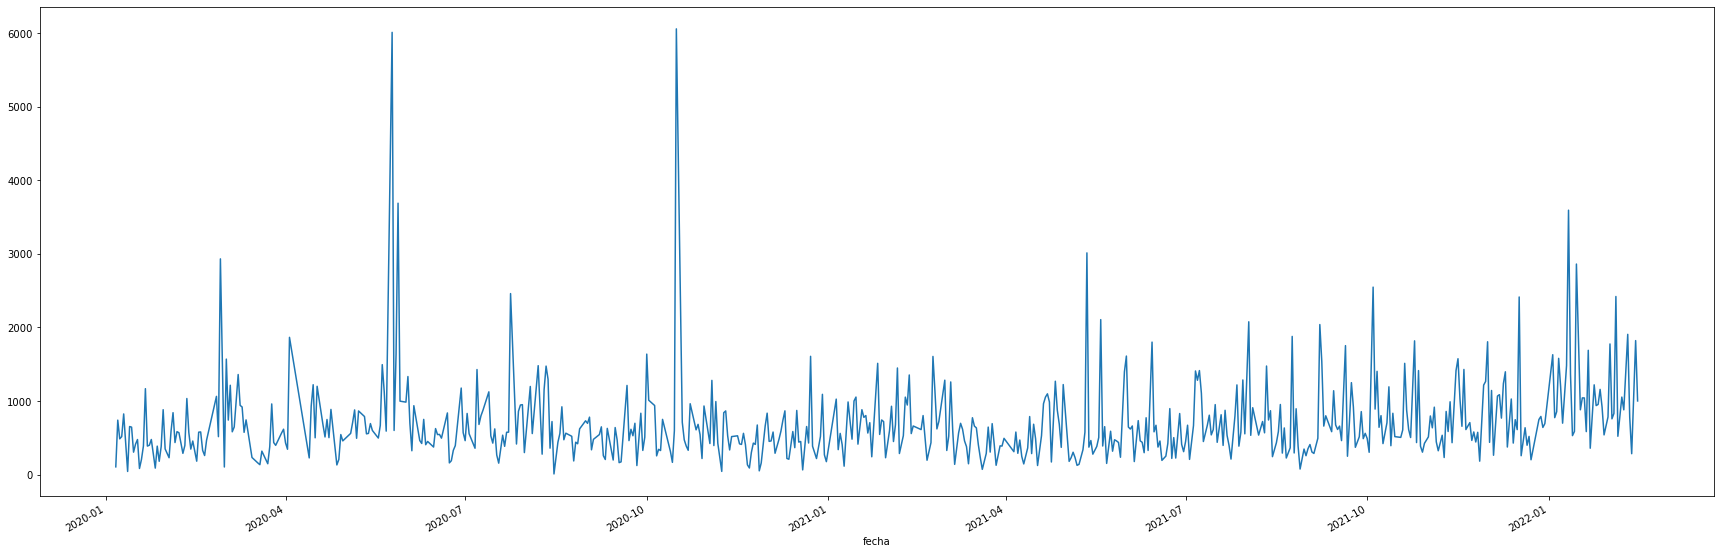

In [53]:
df_ventas_diarias = df_ventas_totales.groupby('fecha').monto_dolar.sum()
df_ventas_diarias.plot(figsize=(30,10))

In [54]:
# Las 25 ventas de mayor monto
df_ventas_totales.groupby('num').monto_dolar.sum().sort_values(ascending=False).head(25)

num
2020-0000004271-fa    5686.278600
2020-0000006335-fa    2977.261000
2020-0000006336-fa    2920.474006
2020-0000004402-fa    2778.282410
2022-0000006399-fa    2280.938776
2021-0000000005-ne    2084.062475
2020-0000000005-ne    2065.660461
2020-0000000108-ne    1866.830040
2021-0000004549-fa    1435.880431
2020-0000004336-fa    1265.419985
2021-0000006281-fa    1219.543568
2020-0000006292-fa    1141.478936
2021-0000006050-fa    1082.725061
2020-0000002238-fa    1016.637129
2020-0000002115-fa    1015.451327
2021-0000005662-ne     983.036638
2021-0000006247-fa     936.853002
2020-0000004530-fa     923.130116
2021-0000006066-fa     846.770992
2021-0000004877-fa     814.357766
2021-0000006119-fa     811.594203
2021-0000004906-fa     794.944316
2021-0000002433-ne     790.209116
2022-0000006221-ne     787.551020
2020-0000000017-ne     785.552448
Name: monto_dolar, dtype: float64

## 8. Carga y limpieza de datos del Inventario<a name="carga-inventario"></a>

Datos sobre el inventario al final del período. Además incluye la clasificación de los productos en líneas de productos.

Con esta información podemos determinar cuáles productos podrían entrar en rotura de stock en función de lo que se ha vendido y lo que queda en stock.

In [55]:
FILE_STOCK = 'datos/in/*inv.xls'

df_stock = read_files(FILE_STOCK, 'fecha', 10)
df_stock.sample(5)

,Código,Descripción,Descrip linea/ validada,SActual,stock real 1,Ajuste(E/S),fecha
1275,01349,"MANGUERA PEAD 110MM/4"" PN8 (120 PSI) GEMACA CA...",MANGUERAS DE RIEGO DE POLIETILENO NEGRA,1.0,NaN,NaN,2022-02-16
3420,05891,REDUCCION PEAD SOLDABLE PN10 110MM*50MM GEMACA,CONEXIONES PLASTICAS DE RIEGO,2.0,NaN,NaN,2022-02-16
2387,04237,"PVC TEE REDUCIDA 75MM/3"" * 50MM/2"" AGUAS NEGR...",PVC TUBERIAS Y ACCESORIOS DE AN,9.0,NaN,NaN,2022-02-16
688,00708,"MANGUERA PEAD 75MM/3"" PN10 (150 PSI) GEMACA CA...",MANGUERAS DE RIEGO DE POLIETILENO NEGRA,0.0,NaN,NaN,2022-02-16
1983,03524,RESPIRADOR UN CARTUCHO POLVOS TOXICOS PRO LIFE...,SEGURIDAD & HIGIENE,1.0,NaN,NaN,2022-02-16


In [56]:
cols = ['cod', 'producto', 'linea', 'stock', 'stock2', 'ajuste', 'fecha_stock']
df_stock.columns = cols
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3607 entries, 0 to 3606
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cod          3607 non-null   object 
 1   producto     3607 non-null   object 
 2   linea        3606 non-null   object 
 3   stock        3606 non-null   float64
 4   stock2       0 non-null      float64
 5   ajuste       0 non-null      float64
 6   fecha_stock  3607 non-null   object 
dtypes: float64(3), object(4)
memory usage: 197.4+ KB


In [57]:
# Guardamos solo la información que nos interesa
df_stock = df_stock.loc[:,['cod', 'producto', 'linea', 'stock', 'fecha_stock']]
df_stock.sample(5)

,cod,producto,linea,stock,fecha_stock
2739,04836,LAMPARA LED HIGH BAY 150W*85-277V*6500K NEGRA ...,ELECTRICIDAD,2.0,2022-02-16
3555,06333,"MALLA ELECTROSOLDADA 1"" * 1""",ALAMBRES Y MALLAS,7.5,2022-02-16
228,00233,SOLDADURA 3/32 FINA AZUL WEST ARCO KILO(60VARI...,GENERALES,4980.0,2022-02-16
2911,05150,BOTAS #39 SEGURIDAD INGCO,SEGURIDAD & HIGIENE,1.0,2022-02-16
1660,02372,PEGATANKE EPOXI 30 MINUTOS ORIGINAL/BLANCA/ACE...,GENERALES,56.0,2022-02-16


In [58]:
# Eliminamos las filas con NaN (total)
# Transformamos los tipos de columnas para que se guarden con
# el tipo correcto
df_stock.dropna(inplace=True)
df_stock.cod = df_stock.cod.astype(str)
df_stock.fecha_stock = pd.to_datetime(df_stock.fecha_stock)

df_stock.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3606 entries, 0 to 3605
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   cod          3606 non-null   object        
 1   producto     3606 non-null   object        
 2   linea        3606 non-null   object        
 3   stock        3606 non-null   float64       
 4   fecha_stock  3606 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 169.0+ KB


## 9. Almacenamiento de los DF<a name="almacenamiento-df"></a>

Los diferentes DF son almacenados en archivos **.parquet** que serán utilizados más tarde en los otros notebooks.

También los guardaremos en archivos **.xlsx** que se utilizarán en la creación de reportes en **Google Data Studio** para failicitar el análisis por parte de los gerentes de la ferretería.

### Ventas Totales

In [59]:
%%time
# Guardamos el DF limpio para su análisis posterior

df_ventas_totales.to_parquet(f"{BASE_DIR / 'datos/out/ventas.parquet'}", 
                    compression='GZIP',
                    engine='pyarrow')

df_ventas_totales.to_csv(f"{BASE_DIR / 'datos/out/ventas.csv'}", sep=';')

# Guardamos el DF en un archivo Excel para utilizar los datos en Google Data Studio
df_ventas_totales.to_excel(f"{BASE_DIR / 'datos/out/ventas.xlsx'}", index = False)

CPU times: user 13.4 s, sys: 160 ms, total: 13.5 s
Wall time: 13.6 s


### Stock

In [60]:
%%time
# Guardamos el DF limpio para su análisis posterior

df_stock.to_parquet(f"{BASE_DIR / 'datos/out/stock.parquet'}", 
                    compression='GZIP',
                    engine='pyarrow')

df_stock.to_csv(f"{BASE_DIR / 'datos/out/stock.csv'}", sep=';')


# Guardamos el DF en un archivo Excel para utilizar los datos en Google Data Studio
df_stock.to_excel(f"{BASE_DIR / 'datos/out/stock.xlsx'}", index = False)


CPU times: user 742 ms, sys: 3.92 ms, total: 746 ms
Wall time: 762 ms


### Archivo Completo Ventas y Sotock

In [61]:
# Archivo completo ventas y stock
df_ventas_prod_stock = pd.merge(df_ventas_totales, df_stock, on=['cod', 'producto'], how='outer')
df_ventas_prod_stock.sample(30)

,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad,fecha,tasa_dolar,monto_dolar,linea,stock,fecha_stock
17979,2021-0000002641-fa,2021-03-15 08:31:00,11.0,0.82,fa,01659,"EXTENSION 1-1/2""*7-1/2"" PLASTICA BLANCA PARA ...",1.0,2021-03-15,1.764917,0.464611,GRIFERIA GENERAL,0.0,2022-02-16
22987,2021-0000003120-fa,2021-03-29 10:21:00,13.0,3.20,fa,05102,COPIA DE LLAVE,2.0,2021-03-29,1.914361,1.671576,GENERALES,42.0,2022-02-16
25069,2021-0000000002-ne,2021-01-26 00:00:00,11.0,0.06,ne,00911,"PUNTO SOLDADURA PEAD DESDE 32MM A 250MM/8""",6.0,2021-01-26,1.740756,0.034468,NaN,NaN,NaT
13098,2021-0000003013-ne,2021-09-27 10:57:00,10.0,6.11,ne,00500,"TEIPE ELECTRICO 3/4""*18MTS NEGRO COBRA",1.0,2021-09-27,3.509485,1.740996,GENERALES,3.0,2022-02-16
35644,2021-0000005580-fa,2021-06-26 09:50:00,1.0,15.68,fa,00515,"REGADOR 1/2"" PLASTICO AMARILLO CON NEGRO/NEGRO...",5.0,2021-06-26,3.062004,5.120830,NaN,NaN,NaT
33413,2022-0000007338-ne,2022-02-01 10:16:00,10.0,7.22,ne,06385,CONFITERIA SUSY MAXI 50GR,2.0,2022-02-01,4.690000,1.539446,CHUCHERIAS,1.0,2022-02-16
10486,2020-0000004422-fa,2020-05-28 12:55:00,10.0,152000.00,fa,,,0.0,2020-05-28,189797.120000,0.800855,NaN,NaN,NaT
36300,2021-0000002311-fa,2021-03-04 14:14:00,10.0,5.00,fa,04580,ALAMBRE C-17.5 LISO HG KILOGRAMO IMPORTADO,1.0,2021-03-04,1.808056,2.765400,ALAMBRES Y MALLAS,0.0,2022-02-16
22036,2021-0000001944-ne,2021-08-21 11:02:00,6.0,22.22,ne,00830,"RIEGO ABRAZADERA PLASTICA 110MM * 2"" AGRO/MOM",1.0,2021-08-21,3.939346,5.640530,CONEXIONES PLASTICAS DE RIEGO,56.0,2022-02-16
38005,2021-0000005370-ne,2021-12-10 09:59:00,11.0,9.60,ne,04362,"LLAVE CHORRO 1/2"" BLANCA ROSCA METAL GDESEO",1.0,2021-12-10,4.710000,2.038217,LLAVES O VALVULAS METALICAS,0.0,2022-02-16


In [62]:
%%time
# Guardamos el DF limpio para su análisis posterior

df_ventas_prod_stock.to_parquet(f"{BASE_DIR / 'datos/out/ventas_stock.parquet'}", 
                    compression='GZIP',
                    engine='pyarrow')

df_ventas_prod_stock.to_csv(f"{BASE_DIR / 'datos/out/ventas_stock.csv'}", sep=';')


# Guardamos el DF en un archivo Excel para utilizar los datos en Google Data Studio
df_ventas_prod_stock.to_excel(f"{BASE_DIR / 'datos/out/ventas_stock.xlsx'}", index = False)


CPU times: user 16.7 s, sys: 116 ms, total: 16.8 s
Wall time: 16.9 s
